In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers as R
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import optimizers as O
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append('../../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../../feature_eng/train_756feats.csv')
train_score = pd.read_csv('../../../data/train_scores.csv')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft"

endings_to_keep = ["-count_bursts", "-word_sent_parag_agg", "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies"]#, "-paussed_features", "time_gaps", "paragraph_ratios"]
endings_to_keep += ["id"]
    
dir_to_save = "dnn0"
# try:
#     os.mkdir(dir_to_save)
# except:
#     print('Already exists')
#     sys.exit()

cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

200


In [4]:
# train_feats = train_feats.drop(['action_time_gap100_max-time_gaps'], axis=1)

In [5]:
# counter = 0
# new_columns = {}
# for col in cols:
#     if col != 'id' and col != 'score':
#         new_columns[col] = counter
#         counter += 1

# train_feats.rename(columns=new_columns, inplace=True)

In [6]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

## Architecture

In [7]:
@tf.keras.utils.register_keras_serializable()
def smish(x):
    return x * K.tanh(K.log(1 + K.sigmoid(x)))

@tf.keras.utils.register_keras_serializable()
class GatedLinearUnit(L.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.linear = L.Dense(units)
        self.sigmoid = L.Dense(units, activation="sigmoid")
        self.units = units

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config
    
    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)
    

@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(L.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.relu_dense = L.Dense(units, activation=smish)
        self.linear_dense = L.Dense(units)
        self.dropout = L.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = L.LayerNormalization()
        self.project = L.Dense(units)

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        x = self.relu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x
    

@tf.keras.utils.register_keras_serializable()
class VariableSelection(L.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = L.Dense(units=num_features, activation="softmax")
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config
    
    def call(self, inputs):
        v = L.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input_ in enumerate(inputs):
            x.append(self.grns[idx](input_))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs
    

@tf.keras.utils.register_keras_serializable()
class VariableSelectionFlow(L.Layer):
    def __init__(self, num_features, units, dropout_rate, dense_units=None, **kwargs):
        super().__init__(**kwargs)
        self.variableselection = VariableSelection(num_features, units, dropout_rate)
        self.split = L.Lambda(lambda t: tf.split(t, num_features, axis=-1))
        self.dense = dense_units
        if dense_units:
            self.dense_list = [L.Dense(dense_units, \
                                       activation='linear') \
                               for _ in tf.range(num_features)
                              ]
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense_units = dense_units
        
    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        config['dense_units'] = self.dense_units
        return config        
    
    def call(self, inputs):
        split_input = self.split(inputs)
        if self.dense:
            l = [self.dense_list[i](split_input[i]) for i in range(len(self.dense_list))]
        else:
            l = split_input
        return self.variableselection(l)

In [8]:
# Define RMSE loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Define MSE loss function
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [9]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps):
        super(LRSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        warmup_factor = tf.minimum(1.0, step / self.warmup_steps)
        return self.initial_learning_rate * warmup_factor

    def reduce_lr(self, factor):
        self.initial_learning_rate *= factor

In [10]:
dense_units = 8

units_1 = 128
drop_1 = 0

units_2 = 128
drop_2 = 0

units_3 = 32
drop_3 = 0

units_4 = 32
drop_4 = 0

num_features = len(train_cols)

# Define the input shape
input_shape = (num_features,)

batch_size = 32

In [11]:
# Define the model
inputs = tf.keras.Input(shape=input_shape)
feat_1 = VariableSelectionFlow(num_features, units_1, drop_1, dense_units)(inputs)
feat_2 = VariableSelectionFlow(units_1, units_2, drop_2, dense_units)(feat_1)
feat_2 += feat_1
feat_3 = VariableSelectionFlow(units_2, units_3, drop_3, dense_units)(feat_2)
feat_4 = VariableSelectionFlow(units_3, units_4, drop_4, dense_units)(feat_3)
feat_4 += feat_3
outputs = tf.keras.layers.Dense(1, activation=lambda x: 6 * tf.sigmoid(x))(feat_4)  # for regression, the final layer has 1 unit
model = Model(inputs=inputs, outputs=outputs)

# Define the optimizer with a linear warmup
warmup_steps = len(train_feats[train_cols]) // batch_size  # number of steps in one epoch
learning_rate = LRSchedule(1e-4, warmup_steps)
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Define the loss function
loss_fn = tf.keras.losses.MeanSquaredError()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 variable_selection_flow (Varia  (None, 128)         10907848    ['input_1[0][0]']                
 bleSelectionFlow)                                                                                
                                                                                                  
 variable_selection_flow_1 (Var  (None, 128)         6999040     ['variable_selection_flow[0][0]']
 iableSelectionFlow)                                                                              
                                                                                              

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
x_train, x_val, y_train, y_val = train_test_split(train_feats[train_cols], train_feats[target_col], stratify=score_transformed, test_size=0.25, random_state=42, shuffle=True)
y_train = y_train + np.random.normal(0, 0.1, y_train.shape)

# Fill na with median
x_train = x_train.fillna(x_train.median())
x_val = x_val.fillna(x_train.median())

# Scale
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_val, y_val, test_size=0.5, random_state=41, shuffle=False)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_dataset_1 = tf.data.Dataset.from_tensor_slices((x_valid1, y_valid1)).batch(batch_size)
val_dataset_2 = tf.data.Dataset.from_tensor_slices((x_valid2, y_valid2)).batch(batch_size)

epochs = 150
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 2
factor = 0.95

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')
    
    # Training loop
    train_loss = 0
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = model(x_batch, training=True)
            # Compute the loss value
            loss_value = loss_fn(y_batch, y_pred)

        # Compute gradients
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Update weights
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_loss += loss_value

    print(f'Training loss(mse): {np.sqrt(float(train_loss/step+1))}')
    
    # Validation loop
    val_loss = []
    for x_batch_val, y_batch_val in val_dataset_1:
        y_val_pred = model(x_batch_val, training=False)
        val_loss_value = root_mean_squared_error(y_batch_val.numpy(), y_val_pred)
        val_loss.append(val_loss_value)
    
    mean_val_loss = np.mean(val_loss)
    print(f'Validation rmse: {mean_val_loss}')

    # Check for early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        model.save(f'{dir_to_save}/model.h5')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            old_lr = float(optimizer.learning_rate(optimizer.iterations))
            optimizer.learning_rate.reduce_lr(factor)
            new_lr = float(optimizer.learning_rate(optimizer.iterations))
            print(f'Reducing learning rate from {old_lr} to {new_lr}.')
        if epochs_no_improve == 10:
            print('Early stopping!')
            break

Starting epoch 1
Training loss(mse): 1.4842874601551344
Validation rmse: 0.9510278701782227
Starting epoch 2
Training loss(mse): 1.3064455077686867
Validation rmse: 0.7754507660865784
Starting epoch 3
Training loss(mse): 1.2424443777057004
Validation rmse: 0.7459850311279297
Starting epoch 4
Training loss(mse): 1.2284630307824764
Validation rmse: 0.7347175478935242
Starting epoch 5
Training loss(mse): 1.2225624024080233
Validation rmse: 0.7401412725448608
Starting epoch 6
Training loss(mse): 1.2133264418989664
Validation rmse: 0.7139506936073303
Starting epoch 7
Training loss(mse): 1.209122854754011
Validation rmse: 0.7195961475372314
Starting epoch 8
Training loss(mse): 1.203907204540352
Validation rmse: 0.7062445878982544
Starting epoch 9
Training loss(mse): 1.2059200566936377
Validation rmse: 0.7094623446464539
Starting epoch 10
Training loss(mse): 1.2013292659206596
Validation rmse: 0.76368248462677
Reducing learning rate from 0.0001 to 9.5e-05.
Starting epoch 11
Training loss(mse)

KeyboardInterrupt: 

In [ ]:
# Load best model
model.load_weights(f'{dir_to_save}/model.h5')

In [ ]:
preds = model.predict(x_valid2)

10/10 [==============================] - 40s 423ms/step


In [ ]:
print('OOF metric = {:.5f}'.format(metrics.mean_squared_error(y_valid2,
                                                            preds,
                                                            squared=False)))

OOF metric = 0.61485


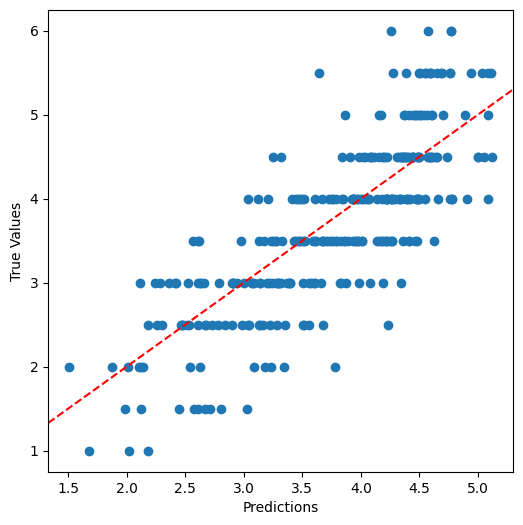

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(preds, y_valid2)
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()